# FLATW'RM

The method from Vida et al.

Let's start with the same dataset as before:

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import matplotlib as mp
import scipy
import pandas
from sklearn import svm
from scipy import ndimage

mp.style.use('seaborn-colorblind')

def lcplot(t,f,color=""):
    '''
    Simple lightcurve plot function
    '''
    mp.rcParams['figure.figsize'] = [12, 6]
    plt.plot(t,f,color+".",alpha=0.1)
    plt.xlabel("Timestamp (days)")
    plt.ylabel(r"SAP flux ($e^-/s$)")

def lcminiplot(t,f,axs,i,j,color=""):
    axs[i,j].plot(t,f,color+".",alpha=0.1)

def slice_t_pdc(t,lc,t0,t1):
    '''
    Returns a tuple (tslice, lcslice) of the time and the lightcurve arrays
    between t0 and t1
    '''
    tslice1 = t[t < t1]
    tslice2 = tslice1[tslice1 > t0]
    lslice1 = lc[t < t1]
    lslice2 = lslice1[tslice1 > t0]
    return (tslice2,lslice2)

WINDOWPERIOD = 0.4
WINDOW_OVERLAP = 7
FIT_DEGREE = 5
hdul = fits.open('tess2019198215352-s0014-0000000159613900-0150-s_lc.fits')
lcdata = hdul[1].data
pdcflux_raw = lcdata.field(7)
time_raw = lcdata.field(0)

First we need the size for the window of the fit.

The size is typically about 1.5 the length of the main period. We also decide to use 7 overlapping windows.

In [2]:
period = 2.59
cadence = len(time_raw)/(time_raw[len(time_raw)-1] - time_raw[0])
windowsize = int(WINDOWPERIOD*period*cadence)
windowstep = int(windowsize/WINDOW_OVERLAP)

In [3]:
def ransac_fit(x,y,nrel=0.03,mrel=0.7,tol=1000.0,max_trials=100):
    
    '''
    Uses RANSAC to fit a model to x,y.
    x, y are arrays
    n is the percentage of samples in the initial model
    mperc is the percentage of datapoints that need to fit
    in a confidence interval from the model
    ci is the confidence interval
    max_trials is the number of attempts
    '''
    
    for i in range(max_trials):
        
        # Choose random samples
        
        n = int(nrel*len(x))
        
        sp_ind = np.random.choice(len(x),n)
        spx = np.zeros(n)
        spy = np.zeros(n)
        for j in range(n):
            spx[j] = x[sp_ind[j]]
            spy[j] = y[sp_ind[j]]
        
        # Fit model
        
        model = np.polyfit(spx,spy,FIT_DEGREE)
        fit = np.poly1d(model)
        
        # Check model
        
        n_in_range = 0
        spp_ind = []
        
        for j in range(len(x)):
            fitj = fit(x[j])
            if np.abs(fitj-y[j]) < tol:
                n_in_range += 1
                spp_ind.append(j)
        
        if (float(n_in_range)/float(len(x)) < mrel):
            continue
            
        # Improve model
        
        sppx = np.zeros(n_in_range)
        sppy = np.zeros(n_in_range)
        
        for j in range(n_in_range):
            sppx[j] = x[spp_ind[j]]
            sppy[j] = y[spp_ind[j]]
        
        model = np.polyfit(sppx, sppy, FIT_DEGREE)
        fit = np.poly1d(model)
        
        return fit
    print("Error: not a good fit!")
    return 0

Then we split the signal into windows and analyze each.

In addition to the RANSAC fit above, I had the idea to use support vector machines for a more robust fit. With this type of data, it seems well justified.

Error: not a good fit!
Error: not a good fit!


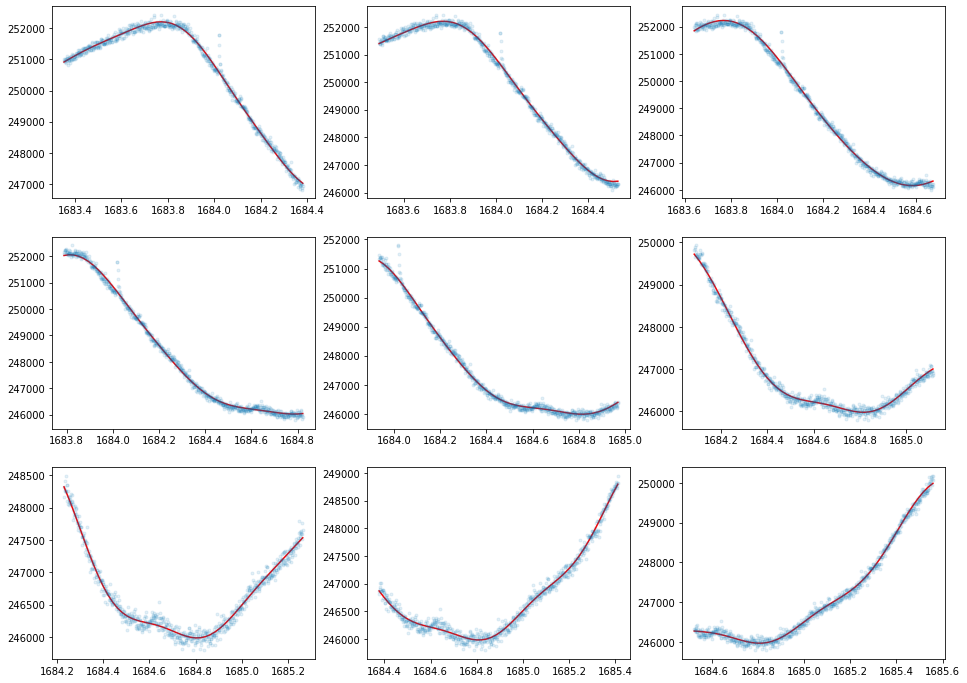

In [4]:
flare_candidates = []
flare_candidate_votes = []

fig, axs = plt.subplots(3,3,figsize=(16,12))

for i in range(0,9*windowstep,windowstep):
    
    # Remove NaNs
    
    windowflux_raw = pdcflux_raw[i:i+windowsize]
    windowtime_raw = time_raw[i:i+windowsize]
    has_errs = np.isnan(windowflux_raw)
    windowflux = windowflux_raw[~has_errs]
    windowtime = windowtime_raw[~has_errs]
    
    fit = ransac_fit(windowtime,windowflux,nrel=0.01,mrel=0.90,tol=300.0,max_trials=10)
    x = np.linspace(np.min(windowtime),np.max(windowtime))
    y = np.zeros(len(x))
    if type(fit) is not int:
        y = fit(x)
    else:
        fit = np.poly1d(np.polyfit(windowtime,windowflux,2))
        y = fit(x)
    
    fit2 = np.poly1d(np.polyfit(windowtime,windowflux,FIT_DEGREE))
    y2 = fit2(x)
    
    meant = np.mean(windowtime)
    stdt = np.std(windowtime)
    meanf = np.mean(windowflux)
    stdf = np.std(windowflux)
    
    wt = [[(t-meant)/stdt] for t in windowtime]
    clf = svm.SVR()
    clf.fit(wt,(windowflux-meanf)/stdf)
    xx = [[(val-meant)/stdt] for val in x]
    y3 = clf.predict(xx)
    y3 = y3*stdf+meanf
    
    k = int(i/windowstep)%3
    j = int((i/windowstep)/3)
    # axs[j,k].plot(x,y,"k")
    # axs[j,k].plot(x,y2,"r--")
    axs[j,k].plot(x,y3,"r")
    lcminiplot(windowtime,windowflux,axs,j,k)

# IDEA: VOTE ALSO ON THE ENERGY OF THE FLARE

It appears that the RANSAC fit is not much different from a regular fit. However the SVM seems to perform quite a bit better. I think I'll use that for the full approach. Let's see how well the model reacts to the gap in the middle of the data.

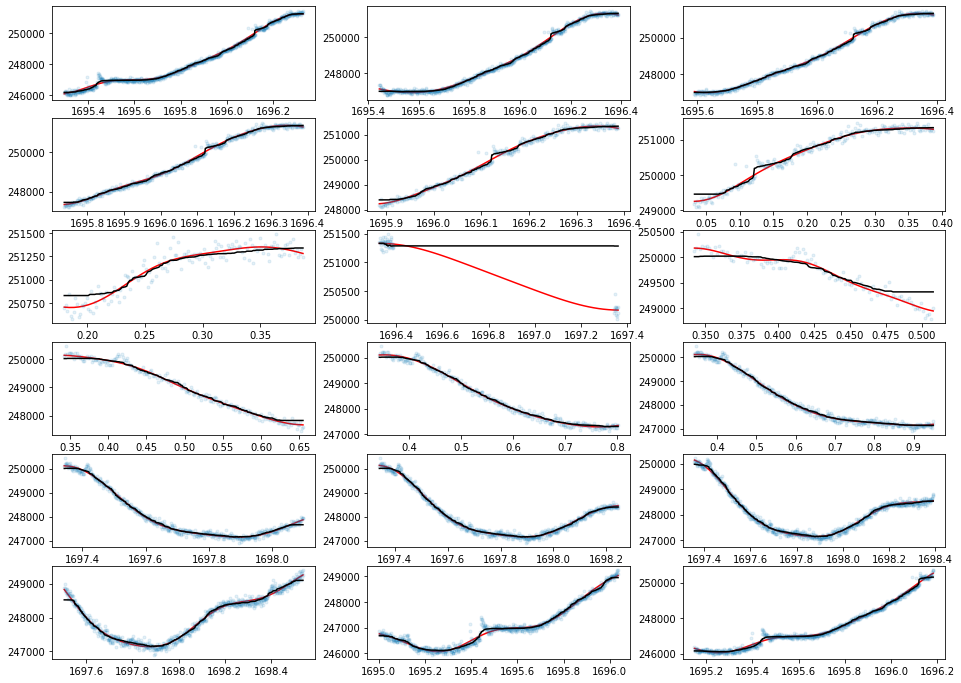

In [5]:
j = -1
fig, axs = plt.subplots(6,3,figsize=(16,12))
for i in range(int(4.5*cadence*period),int(4.5*cadence*period)+18*windowstep,windowstep):
    
    # Remove NaNs
    
    windowflux_raw = pdcflux_raw[i:i+windowsize]
    windowtime_raw = time_raw[i:i+windowsize]
    has_errs = np.isnan(windowflux_raw)
    windowflux = windowflux_raw[~has_errs]
    windowtime = windowtime_raw[~has_errs]
    windowflux_median = ndimage.median_filter(windowflux,size=(100))
    
    # fit = ransac_fit(windowtime,windowflux,nrel=0.01,mrel=0.90,tol=300.0,max_trials=10)
    x = np.linspace(np.min(windowtime),np.max(windowtime))
    y = np.zeros(len(x))
    # if type(fit) is not int:
    #    y = fit(x)
    # else:
    #    fit = np.poly1d(np.polyfit(windowtime,windowflux,2))
    #    y = fit(x)
    
    fit2 = np.poly1d(np.polyfit(windowtime,windowflux,FIT_DEGREE))
    y2 = fit2(x)
    
    meant = np.mean(windowtime)
    stdt = np.std(windowtime)
    meanf = np.mean(windowflux)
    stdf = np.std(windowflux)
    
    wt = [[(t-meant)/stdt] for t in windowtime]
    clf = svm.SVR()
    clf.fit(wt,(windowflux-meanf)/stdf)
    xx = [[(val-meant)/stdt] for val in x]
    y3 = clf.predict(xx)
    y3 = y3*stdf+meanf
    
    k = int(i/windowstep)%3
    if (k == 0):
        j += 1
    # axs[j,k].plot(x,y,"k")
    # axs[j,k].plot(x,y2,"r--")
    axs[j,k].plot(x,y3,"r")
    lcminiplot(windowtime,windowflux,axs,j,k)
    axs[j,k].plot(windowtime,windowflux_median,"k")

plt.show()


So what happens is that the fit will simply ignore the gap. How to deal with this? I propose: **skip over the window if more than a certain percent of the data is NaN.** This also needs to be taken into account when calculating an overall measure of flare activity (how much *effective* time passes in the detection window?)

I suppose it would be best if there was an option in the final program to choose a tolerance for this.

Another thing that appears is that the run-ups and the decays of some apparent flares seem to be unfortunately misfitted. That has been the case with every method so far. Might cause issues for energy calculation. Perhaps those can be compensated by a **Maehara-like method where we detrend based on data before and after the candidate.**

In all, SVM appears superior to RANSAC. Maybe a median filter would also suffice. In any case, the voting system is probably needed for more confidence. Then up to flare detection! Let's pick the flare in the beginning of the upper left plot.

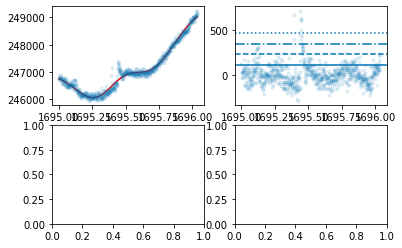

In [6]:
#for i in range(int(4.5*cadence*period),int(4.5*cadence*period)+18*windowstep,windowstep):

i = int(4.5*cadence*period)
    # Remove NaNs
    
# data prep
    
windowflux_raw = pdcflux_raw[i:i+windowsize]
windowtime_raw = time_raw[i:i+windowsize]
has_errs = np.isnan(windowflux_raw)
windowflux = windowflux_raw[~has_errs]
windowtime = windowtime_raw[~has_errs]

# detrending

x = np.linspace(np.min(windowtime),np.max(windowtime))
    
meant = np.mean(windowtime)
stdt = np.std(windowtime)
meanf = np.mean(windowflux)
stdf = np.std(windowflux)
    
wt = [[(t-meant)/stdt] for t in windowtime]
clf = svm.SVR()
clf.fit(wt,(windowflux-meanf)/stdf)
xx = [[(val-meant)/stdt] for val in x]
y3 = clf.predict(xx)
flux_pred = clf.predict(wt)
flux_pred = flux_pred*stdf+meanf
y3 = y3*stdf+meanf

detrend_flux = windowflux-flux_pred
sigma = np.std(detrend_flux)

fig, axs = plt.subplots(2,2)
axs[0,0].plot(x,y3,"r")
lcminiplot(windowtime,windowflux,axs,0,0)
lcminiplot(windowtime,detrend_flux,axs,0,1)
axs[0,1].axhline(sigma,ls="-")
axs[0,1].axhline(2.*sigma,ls="--")
axs[0,1].axhline(3*sigma,ls="-.")
axs[0,1].axhline(4.*sigma,ls=":")

So it would appear that in this lightcurve, we get about $3\sigma$ flares. It would make sense for the final program to maybe vote flares at $3\sigma$ level or above - perhaps **give sensitivity in terms of sigma as an argument**.

For the analysis: it appears that we want an **exponential decay**, fitted so that the signal falls below $\sigma$ or maybe the average - perhaps (time from sensitivity $\rightarrow$ 2x the time to reach $\sigma$). A simple fit should suffice. How to pick out the flares? Perhaps a rule: **3 consecutive data points above the threshold.**

In [14]:
# devlen = n. of consecutive datapoints above 3sigma
devlen = 0
in_flare = False
FLARE_MIN_LEN = 3
flares = []
ongoing_flare = []

for i in range(len(detrend_flux)):
    
    if (detrend_flux[i] > 3.*sigma):
        in_flare = True
        ongoing_flare.append(i)
        devlen += 1
    elif (in_flare):
        in_flare = False
        if (devlen >= FLARE_MIN_LEN):
            flares.append(ongoing_flare)
        ongoing_flare = []
        devlen = 0
        
print(flares)

[[315, 316, 317, 318, 319, 320, 321]]


The above works! So we can use this as a flare detection function in upcoming notebooks. Let's make it so:

In [15]:
def find_flare_indices(flux, min_len, sens):
    """
    Returns a list of index positions for flares in the window of a detrended flux.
    
    flux is necessarily detrended,
    min_len is the minimum duration of a flare in cadences,
    sens is the minimum (eg 3 sigma)
    """
    devlen = 0
    in_flare = False
    flares = []
    ongoing_flare = []

    for i in range(len(detrend_flux)):
    
        if (detrend_flux[i] > 3.*sigma):
            in_flare = True
            ongoing_flare.append(i)
            devlen += 1
        elif (in_flare):
            in_flare = False
            if (devlen >= FLARE_MIN_LEN):
                flares.append(ongoing_flare)
            ongoing_flare = []
            devlen = 0
    
    return flares

And a function to clean the flux and detect the flares inside the window:

In [16]:
def detrended_curve(time, flux):
    
    """
    Fits a support vector machine to the curve (time, flux defined)
    with radial kernel functions; returns the detrended curve.
    requires the line "from sklearn import svm"
    """
    
    meant = np.mean(time)
    stdt = np.std(time)
    meanf = np.mean(flux)
    stdf = np.std(flux)
    
    wt = [[(t-meant)/stdt] for t in time]
    clf = svm.SVR()
    clf.fit(wt,(flux-meanf)/stdf)
    flux_pred = clf.predict(wt)
    return flux_pred*stdf+meanf